In [246]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from regression import ridge_and_lasso, decision_trees, k_nearest_neighbors
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot


In [183]:
def read_data(filepath):
    data = pd.read_excel(filepath, sheet_name = "Data", headers = None)
    data.rename(columns=data.iloc[0], inplace = True)
    data = data[1:]
    data.rename(columns={ data.columns[1]: "tic" }, inplace = True)
    data.rename(columns={ data.columns[0]: "id" }, inplace = True)
    data = data.set_index('tic')


    inter = pd.read_excel(filepath, sheet_name = "Int", headers = None)
    inter.rename(columns=inter.iloc[1], inplace = True)
    inter = inter[2:]
    inter.rename(columns={ inter.columns[1]: "tic" }, inplace = True)
    inter = inter.set_index('tic')
    inter.rename(columns={ inter.columns[0]: "id" }, inplace = True)
    inter['id'] = inter.id.astype(int)
    
    final = pd.read_excel(filepath, sheet_name = "Fnl", headers = None)
    final.columns = ['id', 'tic', 'MktCap', 'Shares', 'AvgV', 'r182', 'r364']
    final = final[3:]
    final['id'] = final.id.astype(int)
    final = final.set_index('tic')

    descr = pd.read_excel(filepath, sheet_name = "Descr", headers = None)
    descr.columns = ['tic', 'Sector', 'Industry', 'Employees']
    del descr['Industry'], descr['Employees']
    descr = descr.set_index('tic')

    return data, inter, final, descr

In [184]:
filepath = "../TestData.1.xlsx"

data, inter, final, descr = read_data(filepath)

## Independent Variables

In [185]:
data

,id,S t+1,S t,St-1,St-2,St-3,St-4,St-5,GPt-1,GPt-2,...,PREFt-5,TEQt-1,TEQt-2,TEQt-3,TEQt-4,TEQt-5,VarT,VarT+1,Srpr1,Srpr4
tic,,,,,,,,,,,,,,,,,,,,,
A,1,5620000,5200000,5160000,4910000,4470000,4200000,4040000,2790000,2680000,...,NaN,4750000,4570000,4830000,4240000,4170000,0.048,0.046,0.164,0.067
AA,2,9470000,8780000,10500000,13520000,11780000,9330000,11220000,1200000,2690000,...,0,4110000,5620000,4520000,5650000,9440000,0.131,0.213,0.042,0.056
AAL,3,29770000,17460000,45770000,44540000,42620000,40180000,40990000,11420000,11020000,...,NaN,-118000,-169000,-780000,3790000,5640000,0.32,0.514,-0.016,-0.031
AAN,4,4450000,4120000,3950000,3830000,3380000,3210000,3180000,1730000,1810000,...,NaN,1740000,1760000,1730000,1480000,1370000,0.019,0.085,0.513,0.142
AAOI,5,259990,219910,190870,267470,382330,260710,189900,45700,87270,...,0,273790,329090,333280,227380,165400,0.153,0.191,-0.158,0.183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNTL,1521,NaN,NaN,NaN,14,NaN,NaN,NaN,-111,NaN,...,NaN,-80110,24770,NaN,NaN,NaN,NaN,NaN,-0.56,NaN
ZSAN,1522,39040,2640,NaN,NaN,NaN,NaN,313,-1520,-764,...,NaN,9390,18710,7050,4490,26500,NaN,0.681,0,0.034
ZTS,1523,6760000,6180000,6260000,5830000,5310000,4890000,4770000,4110000,3800000,...,NaN,2710000,2190000,1770000,1490000,1070000,0.065,0.089,0.105,0.079


## Intermediate Variables - percentage change, ratio

In [186]:
inter


,id,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
tic,,,,,,,,,,,,,,,,
A,1,0.540698,0.179264,0.178101,0.226744,0.207364,0.197674,0.0410448,-463.5,-0.0285412,0.0446429,2.38608,-0.0642202,5620000,5200000,0.0807692
AA,2,0.114286,0.029619,-0.0417143,0.153333,-0.107619,0.0653333,-0.553903,-1.61952,-1.26871,-0.488889,-5.52,0.53125,9470000,8780000,0.0785877
AAL,3,0.249508,0.066856,0.0493773,0.131527,0.0369237,0.0834608,0.0362976,0.204724,0.202128,0.0730838,0.198582,0.082153,29770000,17460000,0.70504
AAN,4,0.437975,0.0254608,0.0234911,0.105889,0.00796709,0.11179,-0.0441989,-0.623742,-0.632078,0.092776,-0.839611,0.238626,4450000,4120000,0.0800971
AAOI,5,0.23943,0,-0.269241,-0.129565,-0.346047,0,-0.476338,NaN,4.2546,-2.30639,29.7209,-1,259990,219910,0.182256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNTL,1521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97866,0.969237,1.16706,0.614021,NaN,NaN,NaN
ZSAN,1522,NaN,NaN,NaN,NaN,NaN,NaN,0.989529,-1,0.0630656,0.0460411,0.0630656,0.162431,39040,2640,13.7879
ZTS,1523,0.65655,0.317891,0.28754,0.388179,0.239617,0.28754,0.0815789,0.0874317,0.0650888,0.109589,0.048951,0.00558659,6760000,6180000,0.0938511


## Dependent Variables

In [187]:
final

,id,MktCap,Shares,AvgV,r182,r364
tic,,,,,,
A,1,30707.7,308310,1330.28,0.498646,0.277414
AA,2,2500.68,185924,4722.64,1.45438,-0.380184
AAL,3,6931.7,508562,69295.1,0.313102,-0.51304
AAN,4,3810.25,67141,688.178,2.78333,-0.057309
AAOI,5,237.533,22774,1008.28,0.547478,-0.064574
...,...,...,...,...,...,...
ZNTL,1521,1260.09,40003,112.559,NaN,NaN
ZSAN,1522,142.638,79686,6755.52,2.72917,-0.0913706
ZTS,1523,76246.5,475145,1498.36,0.589756,0.277424


## Find Correlation btw Intermediate Variables and Final Values

In [188]:
input_variables = inter.columns.to_list()[1:]

In [189]:
output_var = 'r364'
analysis = pd.DataFrame()

# dropping duplicates from final data
final = final[~final.index.duplicated(keep='first')]

inter_tics = list(set(inter.index.tolist()))
final_tics = list(set(final.index.tolist()))

print('Total unique companies : ', len(final_tics))
print('Output variable in consideration: ', output_var)

analysis['output'] = final.loc[final_tics][output_var]

for inter_var in input_variables:
    print("Input variable, ", inter_var)
    analysis[inter_var] = inter.loc[final_tics][inter_var]
    analysis = analysis.dropna()
    print("Companies with valid intermediate, final variables: ", analysis.shape[0])
    corr_spearman, _ = stats.spearmanr(analysis['output'], analysis[inter_var])
    corr_pearson, _ = stats.pearsonr(analysis['output'], analysis[inter_var])
    print("Spearman correlation {}, Pearson correlation {}".format(corr_spearman, corr_pearson))
    print()


Total unique companies :  1525
Output variable in consideration:  r364
Input variable,  Margin_GM
Companies with valid intermediate, final variables:  1267
Spearman correlation -0.020623682237627318, Pearson correlation -0.04757893813026784

Input variable,  Margin_EBITM
Companies with valid intermediate, final variables:  1267
Spearman correlation -0.06316624458186613, Pearson correlation -0.08149889899909599

Input variable,  Margin_PBTM
Companies with valid intermediate, final variables:  1267
Spearman correlation -0.02902153209238004, Pearson correlation -0.07512490646690827

Input variable,  Margin_EBITDAM
Companies with valid intermediate, final variables:  1267
Spearman correlation -0.09383383774526682, Pearson correlation -0.0607684959377386

Input variable,  Margin_NM
Companies with valid intermediate, final variables:  1267
Spearman correlation -0.027989197627145395, Pearson correlation -0.07626996116714344

Input variable,  Margin_OCFM
Companies with valid intermediate, fina

## Sample Analysis

In [190]:
analysis

,output,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
tic,,,,,,,,,,,,,,,,
SYNH,-0.00327749,0.168259,0.0530235,0.0217329,0.124707,0.028047,0.0680513,0.154416,0.590399,0.776284,0.062111,4.4061,0.0602217,5030000,4520000,0.112832
REGN,0.909622,0.874046,0.296438,0.30916,0.307888,0.26972,0.30916,0.120718,-0.064257,-0.0470588,-0.0970149,-0.131148,0.104545,9320000,8170000,0.140759
CEMI,-0.366197,0.350261,-0.386825,-0.411492,-0.310215,-0.396982,-0.262914,0.00751252,38.4379,0.788146,0.586053,0.738247,-0.2309,34310,21690,0.581835
RRGB,-0.574699,0.124826,-0.00970455,-0.0168485,0.076197,-0.00598485,0.0438788,-0.0701467,1.34615,0.0387669,-0.202442,0.23053,-0.541409,1120000,948110,0.181298
NOA,-0.400502,0.133089,0.0817306,0.0517474,0.227711,0.0512885,0.215918,0.359375,0.862758,0.737162,0.811484,1.41203,0.430704,301050,263470,0.142635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LULU,0.601215,0.557789,0.222716,0.225475,0.263819,0.162211,0.163791,0.21978,0.299359,0.254652,0.269757,0.334436,-0.122365,5000000,3970000,0.259446
XENE,0.174468,0,0,-6.0937,-6.20644,-6.09078,-0.677892,-1,-1,0.205678,0.347854,0.205797,-0.866647,19270,35110,-0.451154
ARCB,0.0296514,0.0723846,0.0193579,0.017214,0.0658395,0.0133645,0.0569766,-0.206257,-0.457748,-0.390094,-0.230986,-0.40456,-0.332314,2960000,2780000,0.0647482


## Correlation Matrix

In [191]:
analysis = analysis.astype(np.float64)
corrMatrix = analysis.corr()

corrMatrix

,output,Margin_GM,Margin_EBITM,Margin_PBTM,Margin_EBITDAM,Margin_NM,Margin_OCFM,Growth_GM,Growth_EBITM,Growth_PBTM,Growth_EBITDAM,Growth_NM,Growth_OCFM,Projections_St+1,Projections_St,Projections_SGrt+1
output,1.000000,0.019989,0.016670,-0.199689,-0.201100,-0.199224,-0.200873,0.044339,0.007534,-0.022867,0.012044,-0.021497,-0.002070,-0.114709,0.303743,0.056511
Margin_GM,0.019989,1.000000,0.057518,0.133393,0.134362,0.133375,0.165154,-0.017785,0.003205,-0.010747,-0.033342,0.007962,-0.008509,0.366040,0.333449,-0.038775
Margin_EBITM,0.016670,0.057518,1.000000,0.105959,0.062906,0.105697,0.070812,0.018033,0.006293,-0.004932,-0.014086,-0.021331,0.003956,-0.039951,0.200806,-0.340197
Margin_PBTM,-0.199689,0.133393,0.105959,1.000000,0.998641,0.999996,0.997865,0.001250,-0.000690,-0.003231,-0.026810,-0.012755,0.001646,0.229483,0.355535,-0.119882
Margin_EBITDAM,-0.201100,0.134362,0.062906,0.998641,1.000000,0.998650,0.999219,0.001302,-0.000485,-0.003000,-0.026626,-0.011892,0.001604,0.228488,0.363623,-0.105342
Margin_NM,-0.199224,0.133375,0.105697,0.999996,0.998650,1.000000,0.997867,0.000893,-0.000694,-0.003326,-0.026783,-0.012864,0.001656,0.229243,0.359393,-0.119325
Margin_OCFM,-0.200873,0.165154,0.070812,0.997865,0.999219,0.997867,1.000000,0.002392,-0.000293,-0.003086,-0.027109,-0.012226,0.001651,0.215113,0.369568,-0.117052
Growth_GM,0.044339,-0.017785,0.018033,0.001250,0.001302,0.000893,0.002392,1.000000,-0.001354,-0.002368,-0.029156,-0.007005,-0.001791,0.244897,-0.122903,-0.059831
Growth_EBITM,0.007534,0.003205,0.006293,-0.000690,-0.000485,-0.000694,-0.000293,-0.001354,1.000000,-0.002556,-0.007377,-0.006416,0.001050,-0.248409,0.094650,0.005720
Growth_PBTM,-0.022867,-0.010747,-0.004932,-0.003231,-0.003000,-0.003326,-0.003086,-0.002368,-0.002556,1.000000,0.010328,0.031483,-0.000734,0.124732,-0.185361,0.003265


## Plotting Heatmap

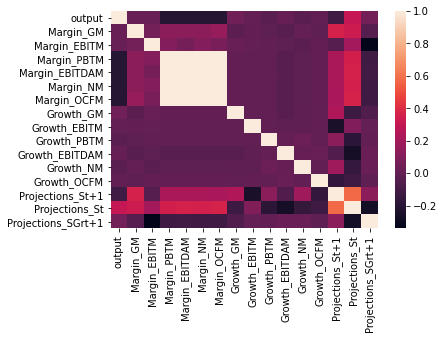

In [192]:
sn.heatmap(corrMatrix, xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns)
plt.show()

### Correlations based on company sector

In [193]:
# Fill in Sector
analysis = analysis.join(descr, on='tic', how='left')
analysis = analysis.dropna()

Basic Materials (76, 17)


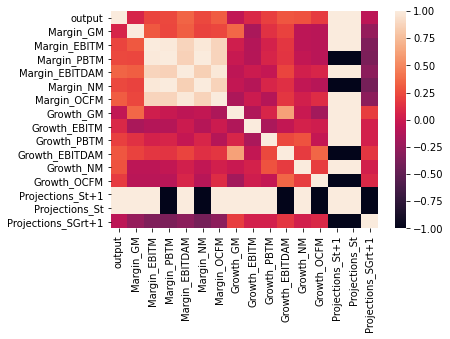

Communication Services (13, 17)


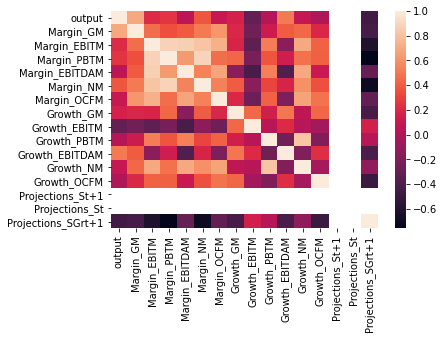

Consumer Cyclical (161, 17)


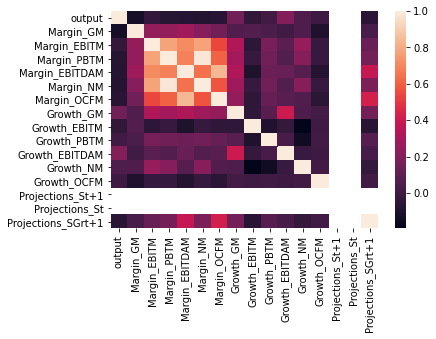

Consumer Defensive (68, 17)


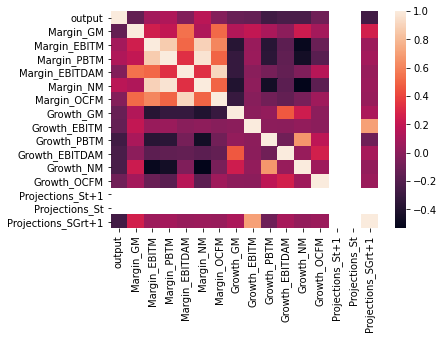

Energy (23, 17)


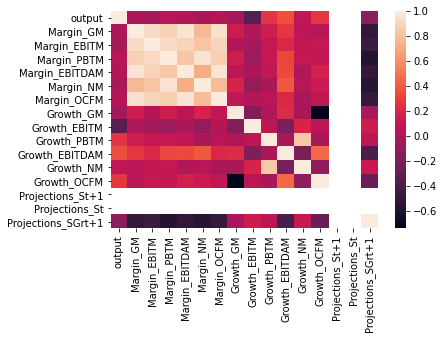

Financial Services (2, 17)


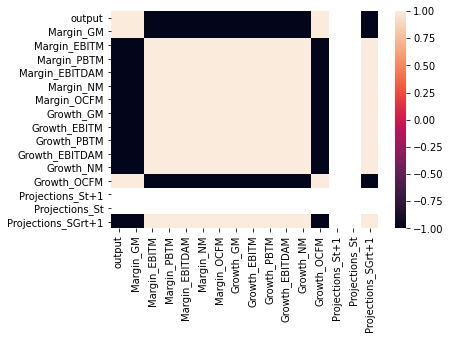

Healthcare (143, 17)


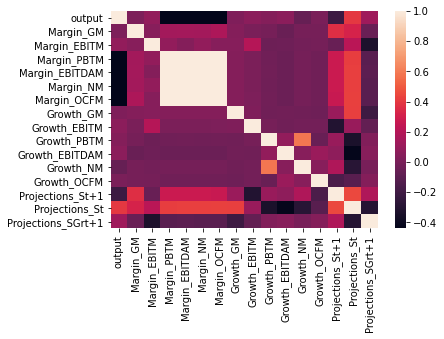

Industrials (128, 17)


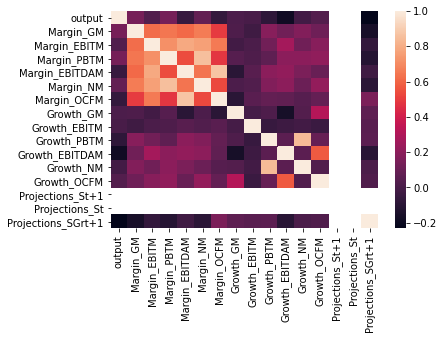

Technology (76, 17)


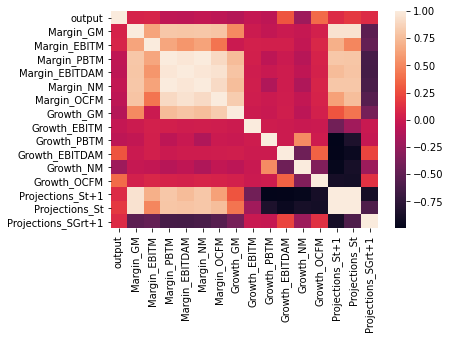

In [203]:

groups = analysis.groupby('Sector')
for sector, df in groups:
    print(sector, df.shape)
    del df['Sector']
    group_analysis = df.astype(np.float64)
    corrMatrix = group_analysis.corr()
    sn.heatmap(corrMatrix, xticklabels=corrMatrix.columns,
        yticklabels=corrMatrix.columns)
    plt.show()  

## Regression Models

In [195]:
# Compute MAE
def compute_error(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

# Compute MSE
def compute_MSE(y, y_hat):
    # mean squared error
    return np.mean(np.power(y - y_hat, 2))

In [224]:
def prepare_data(X, Y):
    X = X.reset_index()
    del X['tic'], X['id']
    Y = Y.reset_index()
    del Y['tic']
    
    ml_data = pd.DataFrame(X)
    ml_data['output'] = pd.DataFrame(Y)

    print(ml_data.shape)

    # del columns with all NAN
    ml_data = ml_data.dropna(axis=1, how='all')
    print(ml_data.shape)    

    # del rows with any NAN 
    ml_data = ml_data.dropna()

    print(ml_data.shape)

    _X = pd.DataFrame(ml_data)
    _Y = _X["output"]
    del _X['output']

    train_x, test_x, train_y, test_y = train_test_split(_X, _Y, shuffle=True, test_size=0.3, random_state=15)

    return train_x, train_y, test_x, test_y

In [254]:
train_x_df, train_y_df, test_x_df, test_y_df = prepare_data(data, final['r182'])

# Requires numpy array for cross-validation in regression.py
train_x = train_x_df.to_numpy()
test_x = test_x_df.to_numpy()
train_y = train_y_df.to_numpy()
test_y = test_y_df.to_numpy()

print('Train=', train_x.shape)
print('Test=', test_x.shape)

(1525, 137)
(1525, 137)
(214, 137)
Train= (149, 136)
Test= (65, 136)


Running decision tree regressor for data type: A
Mean error for data A and hyperparameter 3: 0.6425
--- 360 milli-seconds ---
Mean error for data A and hyperparameter 6: 0.6783
--- 186 milli-seconds ---
Mean error for data A and hyperparameter 9: 0.7697
--- 233 milli-seconds ---
Mean error for data A and hyperparameter 12: 0.6996
--- 249 milli-seconds ---
Mean error for data A and hyperparameter 15: 0.7926
--- 236 milli-seconds ---
Mean error for data A and hyperparameter 20: 0.7655
--- 246 milli-seconds ---
Mean error for data A and hyperparameter 25: 0.7745
--- 237 milli-seconds ---
Mean error for data A and hyperparameter 30: 0.7631
--- 249 milli-seconds ---
Mean error for data A and hyperparameter 35: 0.7619
--- 255 milli-seconds ---
Mean error for data A and hyperparameter 40: 0.7460
--- 265 milli-seconds ---
After cross-val, best depth for data A is 3 with mean Error: 0.6425
Training model on full data
Mean Absolute Error on test set 0.43652519947892315
Printing Predictions
0.468

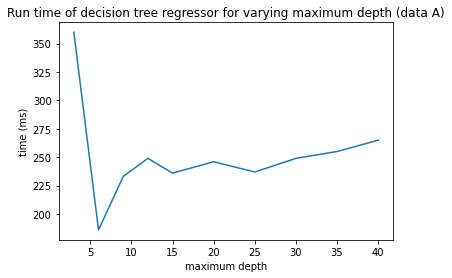

In [261]:
predicted_y = decision_trees('A', train_x, train_y, test_x)
print('Mean Absolute Error on test set', compute_error(predicted_y, test_y))

print('Printing Predictions')
for y_hat, y in zip(predicted_y, test_y):
    print(y, y_hat)

Running k-nearest neighbor regressor for data type: A
Mean error for data A and hyperparameter 3: 0.6167
--- 47 milli-seconds ---
Mean error for data A and hyperparameter 5: 0.5812
--- 28 milli-seconds ---
Mean error for data A and hyperparameter 10: 0.5549
--- 17 milli-seconds ---
Mean error for data A and hyperparameter 20: 0.5501
--- 14 milli-seconds ---
Mean error for data A and hyperparameter 25: 0.5639
--- 16 milli-seconds ---
After cross-val, best neighbors for data A is 20 with mean Error: 0.5501
Training model on full data
Mean Absolute Error on test set 0.4403993817033539


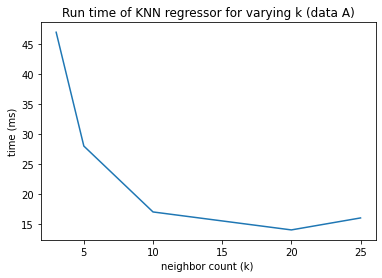

In [256]:
predicted_y = k_nearest_neighbors('A', train_x, train_y, test_x)
print('Mean Absolute Error on test set', compute_error(predicted_y, test_y))

Running ridge regressors for data type: data
Mean error for data data and hyperparameter 1e-06: 311.0285
--- 25 milli-seconds ---
Mean error for data data and hyperparameter 0.0001: 311.0285
--- 22 milli-seconds ---
Mean error for data data and hyperparameter 0.01: 311.0285
--- 21 milli-seconds ---
Mean error for data data and hyperparameter 1: 311.0284
--- 16 milli-seconds ---
Mean error for data data and hyperparameter 10: 311.0284
--- 19 milli-seconds ---
Running lasso regressors for data type: data
Mean error for data data and hyperparameter 1e-06: 2.1146
--- 104 milli-seconds ---
Mean error for data data and hyperparameter 0.0001: 2.1032
--- 113 milli-seconds ---
Mean error for data data and hyperparameter 0.01: 1.7428
--- 87 milli-seconds ---
Mean error for data data and hyperparameter 1: 1.9089
--- 83 milli-seconds ---
Mean error for data data and hyperparameter 10: 1.5884
--- 83 milli-seconds ---
After cross-val, best method for data data is lasso with alpha = 10 and mean Error

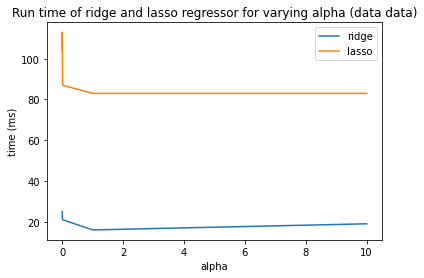

In [257]:
predicted_y = ridge_and_lasso('data', train_x, train_y, test_x)
print('Mean Absolute Error on test set', compute_error(predicted_y, test_y))

### Feature Selection


In [258]:
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    X_train = X_train.astype(np.float64)
    y_train = y_train.astype(np.float64)
    X_test = X_test.astype(np.float64)
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs
 

In [259]:
train_x_df.head()

,S t+1,S t,St-1,St-2,St-3,St-4,St-5,GPt-1,GPt-2,GPt-3,...,PREFt-5,TEQt-1,TEQt-2,TEQt-3,TEQt-4,TEQt-5,VarT,VarT+1,Srpr1,Srpr4
399,7390000,4760000,8740000,8390000,4870000,3880000,3930000,3400000,3070000,1930000,...,0,2130000,3250000,3230000,-1660000,987000,0.607,0.225,-1,-2.046
762,1300000,1200000,1510000,1590000,1400000,1330000,1390000,269500,238500,292200,...,0,733900,740400,746300,804700,774400,0.167,0.1,0.203,0.065
1139,3580000,3180000,3240000,3090000,2970000,3030000,2610000,1360000,1220000,1150000,...,0,4290000,4360000,4780000,4900000,5000000,0.097,0.142,0.18,0.16
1128,443630,157780,634180,593140,230770,0,0,190600,198300,67630,...,0,1240000,1230000,1040000,1110000,967640,0.422,0.261,-0.375,-0.219
1331,9020000,9610000,11930000,12560000,11910000,9300000,8290000,3160000,4450000,4430000,...,0,21300000,22880000,19850000,17440000,16410000,0.338,0.389,-0.021,-0.028


Feature 0: 0.034935
Feature 1: 0.041690
Feature 2: 0.181019
Feature 3: 0.181861
Feature 4: 0.168604
Feature 5: 0.158251
Feature 6: 0.167482
Feature 7: 0.079076
Feature 8: 0.089722
Feature 9: 0.078242
Feature 10: 0.070409
Feature 11: 0.083976
Feature 12: 0.248653
Feature 13: 0.292593
Feature 14: 0.295444
Feature 15: 0.318957
Feature 16: 0.165957
Feature 17: 0.249922
Feature 18: 0.242004
Feature 19: 0.239787
Feature 20: 0.241515
Feature 21: 0.233124
Feature 22: 0.039495
Feature 23: 0.053692
Feature 24: 0.031658
Feature 25: 0.038245
Feature 26: 0.000044
Feature 27: 0.052848
Feature 28: 0.066560
Feature 29: 0.070674
Feature 30: 0.076825
Feature 31: 0.189624
Feature 32: 0.041683
Feature 33: 0.045425
Feature 34: 0.038063
Feature 35: 0.035687
Feature 36: 0.016817
Feature 37: 0.046523
Feature 38: 0.062921
Feature 39: 0.040012
Feature 40: 0.075613
Feature 41: 0.050188
Feature 42: 0.045423
Feature 43: 0.049920
Feature 44: 0.046759
Feature 45: 0.041403
Feature 46: 0.016380
Feature 47: 0.036715
Fe

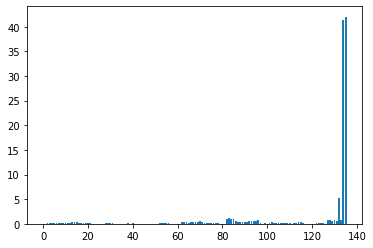

In [260]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(train_x_df, train_y_df, test_x_df)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()